In [1]:
import itertools

import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import check_random_state


def initialize(hidden_dim, output_dim):
    # get mnist data
    mnist = fetch_mldata('MNIST original')
    X = mnist.data.astype('float64')
    y = mnist.target

    # seed for reproducibility
    random_state = check_random_state(0)

    # split data in train test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000,
                                                        test_size=300, random_state=random_state)

    # normalize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # one hot encode labels
    enc = OneHotEncoder(sparse=False)
    y_train = enc.fit_transform(y_train.reshape(len(y_train), 1))
    y_test = enc.transform(y_test.reshape(len(y_test), 1))

    # weights for single hidden layer
    # input size based on data
    W1 = np.random.randn(hidden_dim, X_train.shape[1]) * 0.01
    b1 = np.zeros((hidden_dim,))
    W2 = np.random.randn(output_dim, hidden_dim) * 0.01
    b2 = np.zeros((output_dim,))

    parameters = [W1, b1,
                  W2, b2]

    # return to column vectors as this network was implemented like this
    return parameters, X_train.T, X_test.T, y_train.T, y_test.T


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def dsigmoid(x):
    # input x is already sigmoid, no need to recompute
    return x * (1.0 - x)


def loss(pred, y):
    return np.sum(.5 * np.sum((pred - y) ** 2, axis=0), axis=0) / y.shape[1]


def dloss(pred, y):
    return (pred - y) / y.shape[1]

In [5]:
class NeuralNet(object):

    def __init__(self, hidden_dim, output_dim):
        # size of layers
        self.hidden_dim_1 = hidden_dim
        self.output_dim = output_dim

        # weights and data
        parameters, self.x_train, self.x_test, self.y_train, self.y_test = initialize(hidden_dim, output_dim)
        self.W1, self.b1, self.W2, self.b2 = parameters

        # activations
        batch_size = self.x_train.shape[0]

        self.ai = np.ones((self.x_train.shape[1], batch_size))
        self.ah1 = np.ones((self.hidden_dim_1, batch_size))
        self.ao = np.ones((self.output_dim, batch_size))
        
        # classification output for transformed OHE
        self.classification = np.ones(self.ao.shape)
        
        # container for loss progress
        self.loss = None

    def forward_pass(self, x):
        # input activations
        self.ai = x

        # hidden_1 activations
        self.ah1 = sigmoid(np.dot(self.W1, self.ai) + self.b1[:, np.newaxis])

        # output activations
        self.ao = sigmoid(np.dot(self.W2, self.ah1) + self.b2[:, np.newaxis])

        # transform to OHE for classification
        self.classification = (self.ao == self.ao.max(axis=0, keepdims=0)).astype(float)

    def backward_pass(self):
        # calculate error for output
        out_error = dloss(self.ao, self.y_train)
        out_delta = np.multiply(out_error, dsigmoid(self.ao))

        # calculate error for hidden_1
        hidden_1_error = np.dot(self.W2.T, out_delta)
        hidden_1_delta = np.multiply(hidden_1_error, dsigmoid(self.ah1))

        # derivative for W2/b2 (hidden_1 --> out)
        w2_deriv = np.dot(out_delta, self.ah1.T)
        b2_deriv = np.sum(out_delta, axis=1)

        # derivative for W1/b1 (input --> hidden_1)
        w1_deriv = np.dot(hidden_1_delta, self.ai.T)
        b1_deriv = np.sum(hidden_1_delta, axis=1)

        return [w1_deriv, b1_deriv, w2_deriv, b2_deriv]

    def train(self, epochs, lr):
        
        self.loss = np.zeros((epochs,))
        
        for epoch in range(epochs):
            # compute output of forward pass
            self.forward_pass(self.x_train)

            # compute error
            error = loss(self.ao, self.y_train)
            self.loss[epoch] = error
            
            # print progress 
            if (epoch + 1) % 50 == 0:
                print("Loss for epoch {}/{}: {:.5f}".format(epoch + 1, epochs, error))

            # back prop error
            w1_deriv, b1_deriv, w2_deriv, b2_deriv = self.backward_pass()

            # adjust weights with simple SGD
            self.W1 -= lr * w1_deriv
            self.b1 -= lr * b1_deriv
            self.W2 -= lr * w2_deriv
            self.b2 -= lr * b2_deriv

    def predict(self, x):
        self.forward_pass(x)
        return self.classification

    @staticmethod
    def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    @staticmethod
    def plot_classification_report(cr, with_avg_total=True, cmap=plt.cm.Blues):
        
        print("Classification report:")
        print(cr)

        lines = cr.split('\n')

        classes = []
        plotMat = []
        for line in lines[2 : (len(lines) - 3)]:
            t = line.split()
            classes.append(t[0])
            plotMat.append([float(x) for x in t[1: len(t) - 1]])

        if with_avg_total:
            aveTotal = lines[len(lines) - 1].split()
            classes.append('avg/total')
            vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
            plotMat.append(vAveTotal)


        plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
        plt.title('Classification report')
        plt.colorbar()
        x_tick_marks = np.arange(3)
        y_tick_marks = np.arange(len(classes))
        plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
        plt.yticks(y_tick_marks, classes)
        plt.tight_layout()
        plt.ylabel('Classes')
        plt.xlabel('Measures')

    def visualize_prediction(self, expected, predicted):

        # reverse OHE for confusion matrix, sklearn does not support this
        expected = expected.argmax(axis=1)
        predicted = predicted.argmax(axis=1)

        # plot classification report
        cr = classification_report(expected, predicted)
        plt.figure(0)
        self.plot_classification_report(cr)

        # plot confusion matrix
        cm = confusion_matrix(expected, predicted)
        plt.figure(1)
        self.plot_confusion_matrix(cm, classes=np.unique(expected))

        # plot loss progress
        plt.figure(2)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")

        plt.show()

In [8]:
def run():
    nn = NeuralNet(hidden_dim=50, output_dim=10)
    nn.train(epochs=5000, lr=.1)

    y_hat = nn.predict(nn.x_test)
    nn.visualize_prediction(nn.y_test.T, y_hat.T)

Loss for epoch 50/5000: 0.46168
Loss for epoch 100/5000: 0.45096
Loss for epoch 150/5000: 0.44909
Loss for epoch 200/5000: 0.44830
Loss for epoch 250/5000: 0.44765
Loss for epoch 300/5000: 0.44690
Loss for epoch 350/5000: 0.44593
Loss for epoch 400/5000: 0.44462
Loss for epoch 450/5000: 0.44285
Loss for epoch 500/5000: 0.44042
Loss for epoch 550/5000: 0.43711
Loss for epoch 600/5000: 0.43257
Loss for epoch 650/5000: 0.42642
Loss for epoch 700/5000: 0.41830
Loss for epoch 750/5000: 0.40803
Loss for epoch 800/5000: 0.39586
Loss for epoch 850/5000: 0.38244
Loss for epoch 900/5000: 0.36844
Loss for epoch 950/5000: 0.35424
Loss for epoch 1000/5000: 0.34000
Loss for epoch 1050/5000: 0.32584
Loss for epoch 1100/5000: 0.31196
Loss for epoch 1150/5000: 0.29859
Loss for epoch 1200/5000: 0.28591
Loss for epoch 1250/5000: 0.27397
Loss for epoch 1300/5000: 0.26278
Loss for epoch 1350/5000: 0.25231
Loss for epoch 1400/5000: 0.24250
Loss for epoch 1450/5000: 0.23331
Loss for epoch 1500/5000: 0.22468


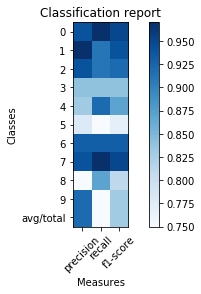

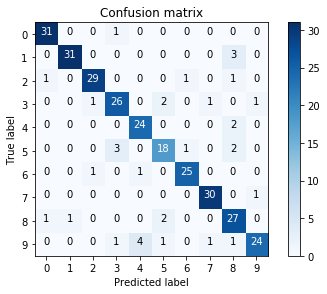

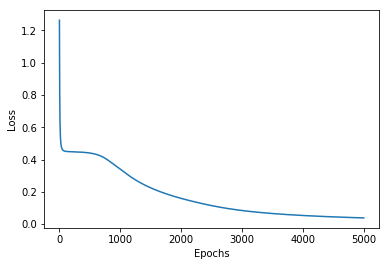

In [9]:
run()